See this page: https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/

MNIST has 70,000 28 pixel x 28 pixel grayscale images of handwritten digits. 

Usually, the task is to classify a given image as a particular digit. 

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context('talk')
sns.set_style("darkgrid", {'axes.grid' : False})

In [44]:
# example of loading the mnist dataset
from keras.datasets.mnist import load_data
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape) #60k training images, each 28x28
print('Test', testX.shape, testy.shape) # 10k testing images, each 28x28

Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


Image of 5


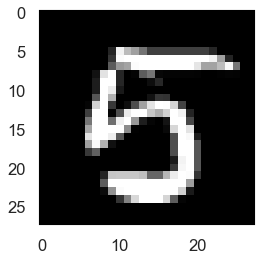

In [45]:
i=np.random.randint(0, high=60000, size=1, dtype='l')[0]
plt.imshow(trainX[i], cmap='gray')
print("Image of " + str(trainy[i]))

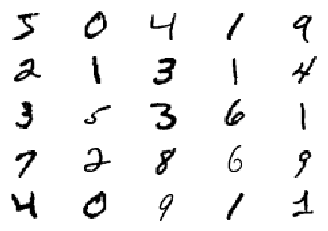

In [46]:
for i in range(25):
    # define subplot
    plt.subplot(5, 5, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(trainX[i], cmap='gray_r')
plt.show()

## First, need to define the Discriminator model

which can take an image from dataset and output a classification prediction (whether it believes the sample is real or fake)

Input: monochromatic image, 28 x 28 pixels

output: binary classication, Real vs Fake

The model will have two convolution layers, each with 64 filters, kernel size 3, and stride 2. It will be trained to minimize the binary cross entropy loss function.

Additionally, we will use the LeakyReLU activation function, dropout (to prevent overfitting), and the adam SGD optimizer. 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

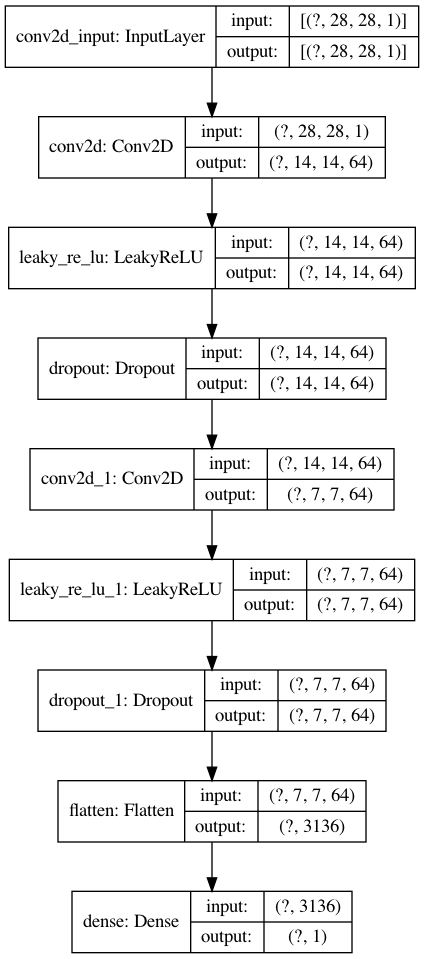

In [5]:
# example of defining the discriminator model
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model
 
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model
 
# define model
model = define_discriminator()
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

In [12]:
def load_real_samples():
    # load mnist dataset
    (trainX, _), (_, _) = load_data()
    #print(trainX.shape)
    #there is only one channel (grayscale) but the conv neural network expects 3D arrays
    X = np.expand_dims(trainX, axis=-1) 
    #print(X.shape)

    #we also want to standardize the values from [0,255] to [0,1]
    # convert from unsigned ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [0,1]
    X = X / 255.0
    #X = X / np.max(X)
    
    return X

In [21]:
#this function will generate a random subsample of images
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1) 
    # 1 does not denote that the digit is a '1', 
    # but that it is a real handwritten digit, not fake
    y = np.ones((n_samples, 1))
    return X, y

### Now we need a model to generate fake images.
These will just be 'white noise' (pixel values uncorrelated point-by-point)

In [22]:
def generate_fake_samples(n_samples):
    # generate uniform random numbers in [0,1]
    X = np.random.rand(28 * 28 * n_samples)
    # reshape into a batch of grayscale images
    X = X.reshape((n_samples, 28, 28, 1))
    # generate 'fake' class labels (0)
    y = np.zeros((n_samples, 1))
    return X, y

### Now we need to train the discriminator model

In [23]:
# train the discriminator model
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_iter):
        # get randomly sampled 'real' images
        X_real, y_real = generate_real_samples(dataset, half_batch)
        # update discriminator on real samples
        _, real_acc = model.train_on_batch(X_real, y_real)
        # generate 'fake' examples
        X_fake, y_fake = generate_fake_samples(half_batch)
        # update discriminator on fake samples
        _, fake_acc = model.train_on_batch(X_fake, y_fake)
        # summarize performance
        print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [24]:
# define the discriminator model
model = define_discriminator()
# load image data
dataset = load_real_samples()
# train the discrimnator model
train_discriminator(model, dataset)

>1 real=16% fake=55%
>2 real=28% fake=74%
>3 real=32% fake=91%
>4 real=30% fake=95%
>5 real=27% fake=99%
>6 real=23% fake=99%
>7 real=34% fake=100%
>8 real=30% fake=100%
>9 real=31% fake=100%
>10 real=30% fake=100%
>11 real=30% fake=100%
>12 real=41% fake=100%
>13 real=39% fake=100%
>14 real=42% fake=100%
>15 real=45% fake=100%
>16 real=50% fake=100%
>17 real=48% fake=100%
>18 real=56% fake=100%
>19 real=62% fake=100%
>20 real=69% fake=100%
>21 real=71% fake=100%
>22 real=84% fake=100%
>23 real=85% fake=100%
>24 real=86% fake=100%
>25 real=89% fake=100%
>26 real=95% fake=100%
>27 real=95% fake=100%
>28 real=96% fake=100%
>29 real=97% fake=100%
>30 real=99% fake=100%
>31 real=99% fake=100%
>32 real=98% fake=100%
>33 real=100% fake=100%
>34 real=99% fake=100%
>35 real=99% fake=100%
>36 real=100% fake=100%
>37 real=100% fake=100%
>38 real=100% fake=100%
>39 real=100% fake=100%
>40 real=100% fake=100%
>41 real=100% fake=100%
>42 real=99% fake=100%
>43 real=100% fake=100%
>44 real=100% fake

### Now we have a trained discriminator model!

### A generator model is supposed to create fake, but plausible images

First, it will draw a sample from the 'latent space', a vector space of Gaussian distributed RVs. 

So it will take an input vector of Gaussian random numbers, and return an output square grayscale image 28x28.

So, we need an operation(s) to transform the input vector of size $N$ into an image of size $28\times 28$.

The first layer will be a dense hidden layer with enough nodes to represent a 'low resolution' version of the output image. Actually, we want many parallell versions of this low-res image. The first layer will allow for 128 parallel versions of the 7x7 feature map. 

Next we need to 'upsample' (or 'deconcolve'), with a 'Conv2dTranpose' layer.

In [28]:
from keras.layers import Reshape
from keras.layers import Conv2DTranspose

# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    # upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    return model

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 28, 28, 128)      

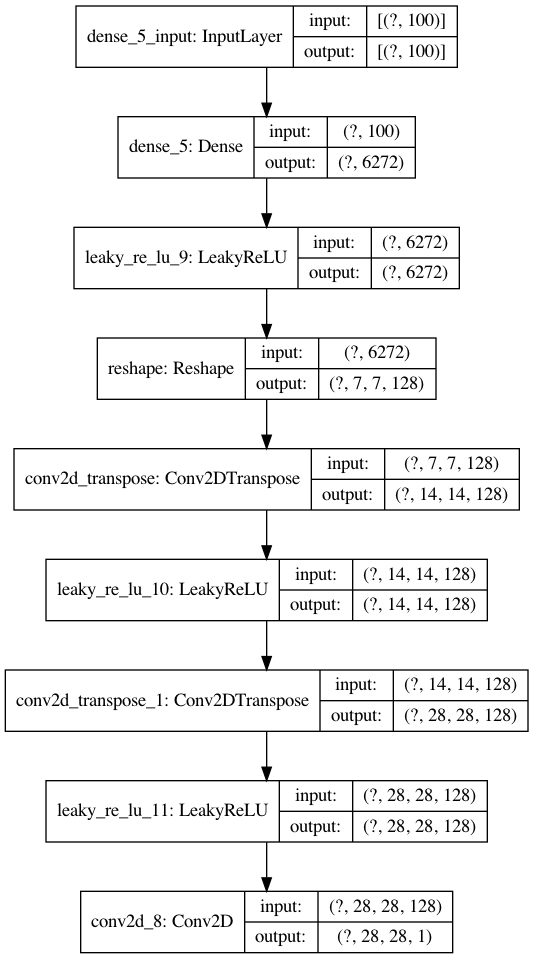

In [29]:
# define the size of the latent space
latent_dim = 100
# define the generator model
model = define_generator(latent_dim)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

In [33]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [34]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = np.zeros((n_samples, 1))
    return X, y

W0222 15:54:53.535354 4701926848 def_function.py:120] 8 out of the last 8 calls to <function Model.make_predict_function.<locals>.predict_function at 0x14b7008c8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


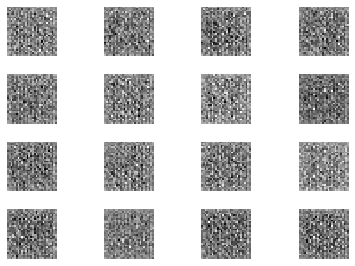

In [49]:
#now lets generate random points in latent space, 
#and push these forward through the (untrained) generative model

# size of the latent space
latent_dim = 100
# define the discriminator model
model = define_generator(latent_dim)
# generate samples
n_samples = 16
X, _ = generate_fake_samples(model, latent_dim, n_samples)
# plot the generated samples
for i in range(n_samples):
    # define subplot
    plt.subplot(4, 4, 1 + i)
    # turn off axis labels
    plt.axis('off')
    # plot single image
    plt.imshow(X[i, :, :, 0], cmap='gray_r')
# show the figure
plt.tight_layout(True)
plt.show()


### Since the generative model hasn't been trained, it just generated noise

The simplest approach is to create a new model that combines the generator and discriminator models

In [50]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable 
    # (it has already been trained, and we don't want these to be altered)
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [51]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# summarize gan model
gan_model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_16 (Sequential)   (None, 28, 28, 1)         1164289   
_________________________________________________________________
sequential_15 (Sequential)   (None, 1)                 40705     
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


In [52]:
# train the composite model
def train_gan(gan_model, latent_dim, n_epochs=100, n_batch=256):
    # manually enumerate epochs
    for i in range(n_epochs):
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)

In [53]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # create training set for the discriminator
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
            # update discriminator model weights
            d_loss, _ = d_model.train_on_batch(X, y)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))

In [54]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    # save plot
    save_plot(x_fake, epoch)
    # save the generator model tile file
    filename = 'generator_model_%03d.h5' % (epoch + 1)
    g_model.save(filename)

In [61]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # create training set for the discriminator
            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
            # update discriminator model weights
            d_loss, _ = d_model.train_on_batch(X, y)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
        # evaluate the model performance, sometimes
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [62]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

>1, 1/234, d=0.682, g=0.785
>1, 2/234, d=0.671, g=0.806
>1, 3/234, d=0.664, g=0.822
>1, 4/234, d=0.656, g=0.850
>1, 5/234, d=0.654, g=0.861
>1, 6/234, d=0.643, g=0.877
>1, 7/234, d=0.641, g=0.891
>1, 8/234, d=0.637, g=0.890
>1, 9/234, d=0.636, g=0.883


KeyboardInterrupt: 